In this notebook we will try to understand how CustomSpaces work and solve Image Similarity problem. We will use CLIP model for embeddings.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import requests
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch

/opt/homebrew/anaconda3/envs/hug_face/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from PIL import Image

First create special dataset to work with images.

In [3]:
import os
data_path = os.path.abspath('..')+'/data/'
pokedex_df = pd.read_csv(data_path+"pokedex.csv").drop(columns=["Unnamed: 0"])
pokedex_df['ability_1'].fillna('None', inplace=True)
pokedex_df['ability_2'].fillna('None', inplace=True)
pd.set_option("display.max_colwidth", 100)

In [4]:
image_data = pokedex_df[['name','sprite']]

In [5]:
image_data

,name,sprite
0,bulbasaur,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1.png
1,ivysaur,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/2.png
2,venusaur,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/3.png
3,charmander,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/4.png
4,charmeleon,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/5.png
...,...,...
1018,gouging-fire,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1020.png
1019,raging-bolt,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1021.png
1020,iron-boulder,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1022.png
1021,iron-crown,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1023.png


In [6]:
from transformers import CLIPModel, CLIPProcessor

Create a class for future Dataloader usage

In [8]:
class PokeImagesDS(Dataset):
    def __init__(self):
        super().__init__()
        self.names = image_data['name'].to_dict()
        self.photo_urls = image_data['sprite'].to_dict()

    def __len__(self):
        return len(self.photo_urls)

    def __getitem__(self, idx):
        images = np.array(Image.open(requests.get(self.photo_urls[idx], stream=True).raw).convert('RGB'))
        names = self.names[idx]
        return names, images

And class for CLIP functionality. We will mostly need only get_image_features() for image embeddings.

In [9]:
class CLIPFeatureExtractor:
    def __init__(self):
        model_name = "openai/clip-vit-base-patch32"
        self.model = CLIPModel.from_pretrained(model_name)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    @torch.no_grad()
    def get_text_features(self, text_data):
        inputs = self.processor(text=text_data, return_tensors="pt", max_length=70, padding="max_length")
        inputs = inputs.to(self.device)
        text_features = self.model.get_text_features(**inputs)
        text_features = text_features.tolist()
        return text_features

    @torch.no_grad()
    def get_image_features(self, images):
        self.processor(images=images, return_tensors="pt")
        inputs = self.processor(images=images, return_tensors="pt")
        inputs = inputs.to(self.device)
        image_features = self.model.get_image_features(**inputs)
        image_features = image_features.tolist()
        return image_features


In [10]:
from tqdm import tqdm

Let us calculate the embeddings of pokemon pictures.

In [13]:
def generate_data():
    batch_size=41
    images_features_list=[]
    dataset = PokeImagesDS()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    feature_extractor = CLIPFeatureExtractor()
    for batch in tqdm(dataloader):
        names, images = batch
        images_features = feature_extractor.get_image_features(images)
        for i in range(len(images)):
            images_features_list.append(images_features[i])
    res = pd.DataFrame({'img_embds':images_features_list})
    return res

In [14]:
res = generate_data()

100%|██████████| 25/25 [06:29<00:00, 15.58s/it]


In [15]:
image_data = pd.concat([image_data, res], axis=1)

In [16]:
import os
data_path = os.path.abspath('..')+'/data/'
data_path

'/Users/benjibred/Projects/Python/PokeApi-with-Superlinked/data/'

In [17]:
image_data.to_csv(data_path+'pokedex_image_search.csv')

In [18]:
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import FloatList
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.space.custom_space import (
    CustomSpace,
)
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.query.param import Param

from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
)
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.query.query import Query

In [19]:
@schema
class Pokemon:
    name: IdField
    img_embds: FloatList  

pokemon = Pokemon()


In [20]:
image_embds_space = CustomSpace(
    vector=pokemon.img_embds,
    length=512,
    aggregation=CustomSpace.AggregationStrategy.SUM_AND_NORMALIZE,
)
poke_index = Index(image_embds_space)

In [21]:
df_parser = DataFrameParser(schema=pokemon)
source: InMemorySource = InMemorySource(pokemon, parser=df_parser)
executor: InMemoryExecutor = InMemoryExecutor(
    sources=[source],
    indices=[poke_index],
)
app = executor.run()
source.put([image_data])

In [22]:
query = (
    Query(poke_index)
    .find(pokemon)
    .similar(image_embds_space.vector, Param("img_embds"))
)

We will use pikachu for our experiment and see how many pokemons look like him.

In [23]:
query_data = image_data.query('name=="pikachu"')['img_embds']

In [112]:
result = app.query(query, img_embds=list(query_data)[0])
result = result.to_pandas().query('similarity_score > 0.9').drop(['img_embds'], axis=1).head(9)
result

,name,similarity_score
0,pikachu,1.000000
1,pichu,0.950202
2,raichu,0.940486
3,morpeko-full-belly,0.931522
4,makuhita,0.930270
5,sandshrew,0.926308
6,plusle,0.923829
7,minun,0.920932
8,corsola,0.914192


Let us look at them and see if they really look alike.

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
res_list = result.values
list_images = []
list_captions = []
for el in res_list:
    list_images.append(image_data.query('name==@el[0]')['sprite'].item())
    list_captions.append([el[0]+' '+str(el[1])[:5]])
    # images.append({el[0]+' '+str(el[1])[:5]:image_data.query('name==@el[0]')['sprite'].item()})

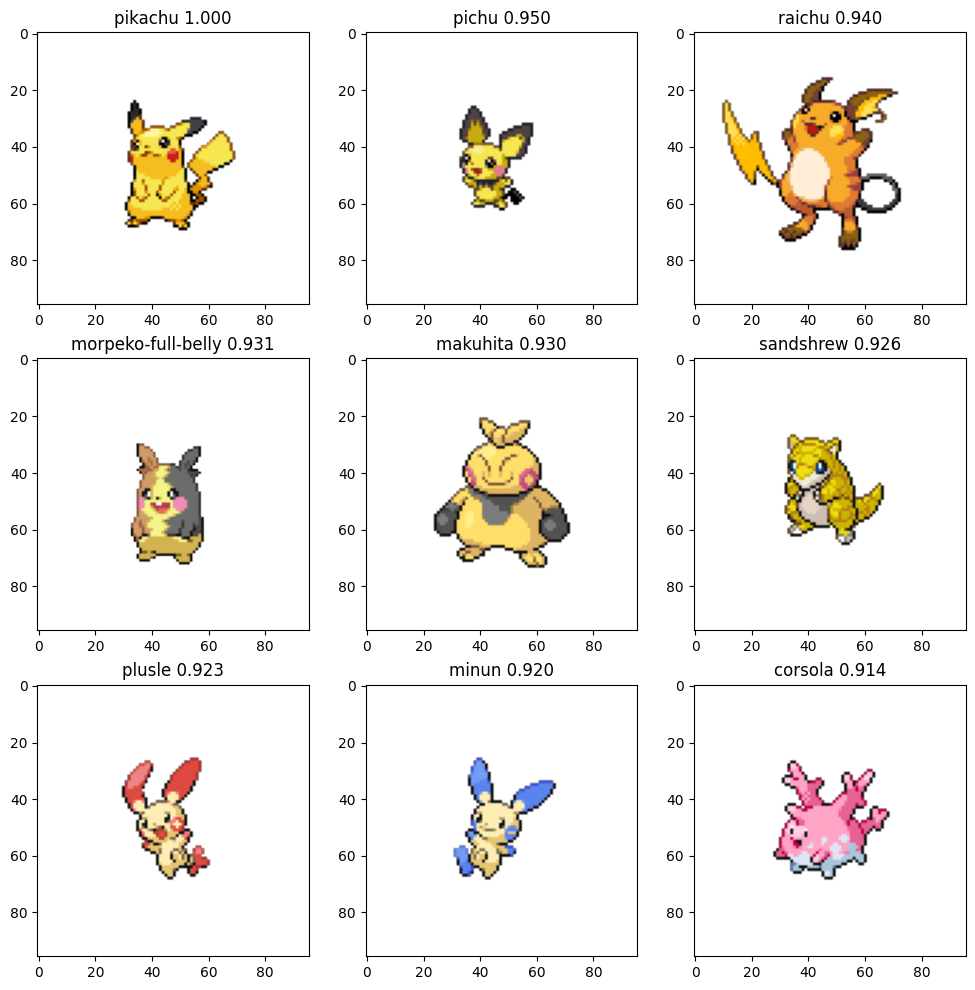

In [114]:
n_row = n_col = 3
_, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
axs = axs.flatten()
for img, ax, caption in zip(list_images, axs, list_captions):
    ax.imshow(Image.open(requests.get(img, stream=True).raw))
    ax.title.set_text(caption[0])
plt.show()